`antman` kernel

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import Bio.SeqIO as SeqIO
import sys
from tqdm import tqdm
import os 
import re
from pygenomeviz import GenomeViz
import scipy.stats as stats
import seaborn as sns
sys.path.append('../')
from transcriptomics import *
from hcr import * 
from plotting import * 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
white_plotting()

Initializing transcriptomics package
Initializing HCR package
Initializing plotting package


In [2]:
tr = load_transcriptome_object("../raw-data/OBir/transcriptome/biroi_transcriptome.pkl")

In [3]:
# Load or_db
or_db = pd.read_excel('../raw-data/OBir/ORs/OR List.xlsx') 
or_db.loc[or_db.gene_name.isin(['Or5-9E198', 'Or5-9E200', 'Or5-9E201']), 'tandem_array'] = 35

In [4]:
# iterate through each row of or_db 
for i, row in or_db.iterrows(): 
    gene = tr.get_gene(row.gene_name) 
    transcript = gene.get_transcript_longest_cds()
    bounds = transcript.get_bounds()
    or_db.at[i, 'n_transcripts'] = len(gene.transcripts)
    or_db.at[i,'start'] = bounds[0]
    or_db.at[i,'end'] = bounds[1] 
    if len(transcript.cds) > 0:
        or_db.at[i,'cds_start'] = int(transcript.cds[0].position[0]) if transcript.strand == '+' and len(transcript.cds) > 0 else int(transcript.cds[0].position[1])
    or_db.at[i,'strand'] = transcript.strand 
    or_db.at[i, 'chr'] = transcript.chromosome
    or_db.at[i,'nine_exon'] = "9E" in row['gene_name']
    or_db.at[i,'ta_size'] = or_db.loc[or_db.tandem_array == row['tandem_array']].shape[0]
    or_db.at[i,'ta_index'] = or_db.loc[or_db.tandem_array == row['tandem_array']].index.get_loc(i) + 1
or_db['start'] = or_db['start'].astype(int)
or_db['end'] = or_db['end'].astype(int)
or_db['ta_size'] = or_db['ta_size'].astype(int)
or_db['ta_index'] = or_db['ta_index'].astype(int)
or_db.head(5)

,chromosome,gene_name,tandem_array,rank,orientation,n_transcripts,start,end,cds_start,strand,chr,nine_exon,ta_size,ta_index
0,1,Or5-R2,70,1,3',1.0,6504395,6510987,6510023.0,-,Chr1,False,2,1
1,1,Or5-Q1,70,2,5',1.0,6511625,6514800,6514732.0,-,Chr1,False,2,2
2,1,Or5-Orco,72,3,NaN,1.0,10910490,10919026,10911295.0,+,Chr1,False,2,1
3,1,Or5-Q2,72,4,NaN,2.0,10934666,10938750,10934709.0,+,Chr1,False,2,2
4,1,Or5-9E1,73,5,NaN,7.0,10980671,10984094,10981538.0,+,Chr1,True,1,1


In [5]:
# Load genome
genome_path = "../raw-data/OBir/genome/Obir.assembly.v5.4.fasta"
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_path, "fasta"))

### Load csRNA-seq Data

In [6]:
# Load csRNAseq data
csRNAseq_dir = "../raw-data/OBir/csRNAseq/"
csRNAseq_files = [f for f in os.listdir(csRNAseq_dir) if f.endswith('.bedGraph')]
print(f"Found {len(csRNAseq_files)} csRNAseq files.")
print(csRNAseq_files)

Found 4 csRNAseq files.
['Ooceraea_biroi-WholeAdults_csRNA-r1.negStrand.renamed.bedGraph', 'Ooceraea_biroi-WholeAdults_sRNA-r1.posStrand.renamed.bedGraph', 'Ooceraea_biroi-WholeAdults_sRNA-r1.negStrand.renamed.bedGraph', 'Ooceraea_biroi-WholeAdults_csRNA-r1.posStrand.renamed.bedGraph']


In [7]:
# Specify adult csRNAseq data, pos and neg strands 
csWAneg_path = os.path.join(csRNAseq_dir, 'Ooceraea_biroi-WholeAdults_csRNA-r1.negStrand.renamed.bedGraph')
csWApos_path = os.path.join(csRNAseq_dir, 'Ooceraea_biroi-WholeAdults_csRNA-r1.posStrand.renamed.bedGraph')

In [8]:
csWAneg = pd.read_csv(csWAneg_path, sep="\t", header=None, names=["chrom", "start", "end", "value"])
csWAneg['strand'] = '-' 
csWApos = pd.read_csv(csWApos_path, sep="\t", header=None, names=["chrom", "start", "end", "value"])
csWApos['strand'] = '+'
csWA = pd.concat([csWAneg, csWApos], ignore_index=True)
csWA

,chrom,start,end,value,strand
0,"track type=bedGraph name=""Ooceraea_biroi-Whole...",NaN,NaN,NaN,-
1,Chr1,110792.0,110823.0,-1.24,-
2,Chr1,122682.0,122683.0,-1.24,-
3,Chr1,122683.0,122684.0,-4.96,-
4,Chr1,122684.0,122714.0,-6.21,-
...,...,...,...,...,...
920935,QOIP01000080.1,13168.0,13172.0,3.72,+
920936,QOIP01000080.1,13172.0,13173.0,4.96,+
920937,QOIP01000080.1,13173.0,13174.0,8.69,+
920938,QOIP01000093.1,6524.0,6549.0,1.24,+


In [9]:
# Drop rows with NaN in value column, reset index, also drop rows without "Chr" in the chrom 
csWA = csWA.dropna(subset=['value'])
csWA = csWA[csWA['chrom'].str.contains("Chr")]
csWA = csWA.reset_index(drop=True)  
csWA['start'] = csWA['start'].astype(int)
csWA['end'] = csWA['end'].astype(int)
csWA['value'] = np.abs(csWA['value'])  # Ensure values are positive
csWA['length'] = csWA['end'] - csWA['start']
csWA['location'] = csWA['chrom'] + ':' + csWA['start'].astype(str) + '-' + csWA['end'].astype(str)
csWA

,chrom,start,end,value,strand,length,location
0,Chr1,110792,110823,1.24,-,31,Chr1:110792-110823
1,Chr1,122682,122683,1.24,-,1,Chr1:122682-122683
2,Chr1,122683,122684,4.96,-,1,Chr1:122683-122684
3,Chr1,122684,122714,6.21,-,30,Chr1:122684-122714
4,Chr1,138377,138407,2.48,-,30,Chr1:138377-138407
...,...,...,...,...,...,...,...
920146,Chr14,8701726,8701732,6.21,+,6,Chr14:8701726-8701732
920147,Chr14,8701732,8701733,4.97,+,1,Chr14:8701732-8701733
920148,Chr14,8701733,8701756,3.73,+,23,Chr14:8701733-8701756
920149,Chr14,8702324,8702344,1.25,+,20,Chr14:8702324-8702344


### Specify windows upstream of ORs to search for csRNA-seq reads

Take a 1kbp window upstream of the CDS start site

In [10]:
# Specify regions of interest (1kbp upstream of each OR's CDS start)
dist_upstream = 1000 

OR_rois = [] 

for i, row in or_db.iterrows():
    if pd.isna(row['chr']) or pd.isna(row['cds_start']):
        continue
    chrom = row['chr']
    chrom_num = int(chrom.replace('Chr', ''))  # Convert 'Chr1' to 1, 'Chr2' to 2, etc.
    strand = row['strand']
    start = row['cds_start'] - dist_upstream if strand == '+' else row['cds_start']
    end = row['cds_start'] if strand == '+' else row['cds_start'] + dist_upstream
    roi = {'chrom': chrom, 'chrom_num': chrom_num, 'start': start, 'end': end, 'strand': strand, 'gene_name': row['gene_name']}
    OR_rois.append(roi)

OR_rois = pd.DataFrame(OR_rois)
# Convert start and end to ints
OR_rois['start'] = OR_rois['start'].astype(int)
OR_rois['end'] = OR_rois['end'].astype(int)
OR_rois

,chrom,chrom_num,start,end,strand,gene_name
0,Chr1,1,6510023,6511023,-,Or5-R2
1,Chr1,1,6514732,6515732,-,Or5-Q1
2,Chr1,1,10910295,10911295,+,Or5-Orco
3,Chr1,1,10933709,10934709,+,Or5-Q2
4,Chr1,1,10980538,10981538,+,Or5-9E1
...,...,...,...,...,...,...
493,Chr12,12,8807087,8808087,+,Or5-L35
494,Chr12,12,12304782,12305782,+,Or5-9E350
495,Chr12,12,13237580,13238580,-,Or5-9E351
496,Chr12,12,13619576,13620576,-,Or5-9Efrag3


In [11]:
# Convert OR_rois to a numpy array 
OR_rois_array = OR_rois[['chrom', 'start', 'end']].to_numpy()

# Use the first column to filter 
OR_rois_array_dict = {}
for chrom, start, end in OR_rois_array:
    if chrom not in OR_rois_array_dict:
        OR_rois_array_dict[chrom] = []
    OR_rois_array_dict[chrom].append((start, end))

In [12]:
OR_rois_array_dict.keys()

dict_keys(['Chr1', 'Chr2', 'Chr3', 'Chr4', 'Chr5', 'Chr6', 'Chr7', 'Chr8', 'Chr9', 'Chr10', 'Chr11', 'Chr12', 'Chr14'])

### Take intersection to remove non-OR-related csRNA-seq Data

In [13]:
# Drop rows where chrom is not in OR_rois_array_dict keys 
csWA = csWA[csWA['chrom'].isin(OR_rois_array_dict.keys())].reset_index(drop=True)

In [14]:
# Take intersection of csRNAseq data with OR regions of interest
from tqdm import tqdm

# Initialize a list to store overlapping regions
overlapping = np.zeros(csWA.shape[0], dtype=bool)

for i, row in tqdm(csWA.iterrows(), total=csWA.shape[0], desc="Processing csRNAseq data"):
    OR_rois_chrom = OR_rois_array_dict[row['chrom']]
    for start, end in OR_rois_chrom:
        if start <= row['start'] and row['end'] <= end:
            # Overlapping region found
            overlapping[i] = True
            break


Processing csRNAseq data: 100%|██████████| 893560/893560 [00:42<00:00, 21101.50it/s]


In [15]:
# Look for overlapping regions
csWA['overlapping'] = overlapping
print(f"Number of overlapping regions: {np.sum(overlapping)} out of {csWA.shape[0]} total regions.")

# Filter csWA to keep only overlapping regions
csWA = csWA[csWA['overlapping']].reset_index(drop=True)

# Drop the 'overlapping' column
csWA = csWA.drop(columns=['overlapping'])

Number of overlapping regions: 869 out of 893560 total regions.


In [16]:
save_1 = csWA.copy() 

In [17]:
csWA = save_1.copy()

In [18]:
# Save gene name and strand information from OR_rois to csWA
for i, row in tqdm(csWA.iterrows(), total=csWA.shape[0], desc="Processing csRNAseq data"):
    # Find row in OR_rois 
    for j, or_row in OR_rois.iterrows():
        if row['chrom'] == or_row['chrom'] and row['start'] >= or_row['start'] and row['end'] <= or_row['end']:
            # Found a matching OR region
            csWA.at[i, 'gene_name'] = or_row['gene_name']
            csWA.at[i, 'gene_strand'] = or_row['strand']
            break

Processing csRNAseq data: 100%|██████████| 869/869 [00:02<00:00, 331.37it/s]


In [19]:
# Look for Nan Rows 
csWA[csWA.isna().any(axis=1)]

,chrom,start,end,value,strand,length,location,gene_name,gene_strand


In [20]:
csWA

,chrom,start,end,value,strand,length,location,gene_name,gene_strand
0,Chr1,16155170,16155188,1.23,-,18,Chr1:16155170-16155188,Or5-D2,+
1,Chr1,16155188,16155212,2.47,-,24,Chr1:16155188-16155212,Or5-D2,+
2,Chr1,16155212,16155214,1.23,-,2,Chr1:16155212-16155214,Or5-D2,+
3,Chr1,16155214,16155224,2.47,-,10,Chr1:16155214-16155224,Or5-D2,+
4,Chr1,16155224,16155252,1.23,-,28,Chr1:16155224-16155252,Or5-D2,+
...,...,...,...,...,...,...,...,...,...
864,Chr12,8808077,8808079,73.23,+,2,Chr12:8808077-8808079,Or5-L35,+
865,Chr12,8808079,8808080,71.99,+,1,Chr12:8808079-8808080,Or5-L35,+
866,Chr12,8808080,8808082,70.75,+,2,Chr12:8808080-8808082,Or5-L35,+
867,Chr12,8808082,8808084,68.27,+,2,Chr12:8808082-8808084,Or5-L35,+


### Merge Overlapping Reads

In [21]:
# find where gene_name is Or5-E11
csWA[csWA['gene_name'] == 'Or5-E11']

,chrom,start,end,value,strand,length,location,gene_name,gene_strand
146,Chr9,14870015,14870058,1.23,-,43,Chr9:14870015-14870058,Or5-E11,-
147,Chr9,14870058,14870063,2.48,-,5,Chr9:14870058-14870063,Or5-E11,-
148,Chr9,14870063,14870066,8.68,-,3,Chr9:14870063-14870066,Or5-E11,-
149,Chr9,14870066,14870080,9.92,-,14,Chr9:14870066-14870080,Or5-E11,-
150,Chr9,14870080,14870103,11.16,-,23,Chr9:14870080-14870103,Or5-E11,-
151,Chr9,14870103,14870127,1.23,-,24,Chr9:14870103-14870127,Or5-E11,-
152,Chr9,14870131,14870165,1.23,-,34,Chr9:14870131-14870165,Or5-E11,-


In [22]:
# Assuming csWA is already sorted by chrom and start
csWA = csWA.sort_values(by=['chrom', 'start']).reset_index(drop=True)

# Initialize a list to store the merged rows
merged_rows = []

# Initialize the previous row as None to start the first merge
previous_row = None

# Iterate through each row
for i in range(len(csWA)):
    row = csWA.iloc[i].copy()
    
    if previous_row is None:
        # The first region becomes the initial "merged" row
        previous_row = row.copy() 
        continue
    
    # Check if the current row overlaps with the previous row (current merged region)
    if (row['chrom'] == previous_row['chrom'] and
        row['strand'] == previous_row['strand'] and
        row['start'] <= previous_row['end']):
        
        # Merge: Extend the end of the merged region
        previous_row['end'] = max(previous_row['end'], row['end'])
        previous_row['length'] = previous_row['end'] - previous_row['start']
        previous_row['location'] = previous_row['chrom'] + ':' + str(previous_row['start']) + '-' + str(previous_row['end'])

        # Take the weighted mean of 'value'
        previous_row['value'] = (previous_row['value'] * previous_row['length'] + row['value'] * row['length']) / (previous_row['length'] + row['length'])
    else:
        # If no overlap, add the previous row to the merged rows and start a new merged region
        merged_rows.append(previous_row)
        previous_row = row.copy()  # Update the previous_row to the current row

# After the loop, append the last region (since it hasn't been added yet)
merged_rows.append(previous_row)

# Convert the list of merged rows back into a DataFrame
csWA_merged = pd.DataFrame(merged_rows).reset_index(drop=True)
csWA_merged

,chrom,start,end,value,strand,length,location,gene_name,gene_strand
0,Chr1,10910413,10910497,17.567543,+,84,Chr1:10910413-10910497,Or5-Orco,+
1,Chr1,10934665,10934691,2.480000,+,26,Chr1:10934665-10934691,Or5-Q2,+
2,Chr1,16155170,16155252,1.645712,-,82,Chr1:16155170-16155252,Or5-D2,+
3,Chr1,16155761,16155791,2.470000,-,30,Chr1:16155761-16155791,Or5-D2,+
4,Chr1,16155928,16155955,1.240000,+,27,Chr1:16155928-16155955,Or5-D2,+
...,...,...,...,...,...,...,...,...,...
284,Chr9,14882134,14882154,3.720000,-,20,Chr9:14882134-14882154,Or5-E14,-
285,Chr9,14888724,14888766,2.480000,-,42,Chr9:14888724-14888766,Or5-E15,-
286,Chr9,14888785,14888836,56.601292,-,51,Chr9:14888785-14888836,Or5-E15,-
287,Chr9,14888845,14888887,2.428719,-,42,Chr9:14888845-14888887,Or5-E15,-


In [23]:
save_2 = csWA_merged.copy()

In [24]:
csWA = csWA_merged.copy()

In [25]:
csWA = csWA.sort_values(by=['value'], ascending=False)

In [26]:
csWA.head(10)

,chrom,start,end,value,strand,length,location,gene_name,gene_strand
184,Chr4,10527180,10527236,562.590346,+,56,Chr4:10527180-10527236,Or5-9E108,-
20,Chr10,1963639,1963688,473.125627,+,49,Chr10:1963639-1963688,Or5-9E241,-
109,Chr12,8761335,8761369,311.071569,+,34,Chr12:8761335-8761369,Or5-L22,+
199,Chr4,10603206,10603259,101.522030,+,53,Chr4:10603206-10603259,Or5-9E118,-
264,Chr7,5138097,5138138,95.484292,-,41,Chr7:5138097-5138138,Or5-U64,+
186,Chr4,10543210,10543252,64.611289,+,42,Chr4:10543210-10543252,Or5-9E110,-
21,Chr10,1976532,1976626,62.659864,+,94,Chr10:1976532-1976626,Or5-9E243,-
189,Chr4,10566339,10566381,60.505970,+,42,Chr4:10566339-10566381,Or5-9E113,-
191,Chr4,10576216,10576262,59.371470,+,46,Chr4:10576216-10576262,Or5-9E114,-
114,Chr12,8808055,8808084,57.083637,+,29,Chr12:8808055-8808084,Or5-L35,+


In [27]:
# find where gene_name is Or5-E11
csWA[csWA['gene_name'] == 'Or5-E11']

,chrom,start,end,value,strand,length,location,gene_name,gene_strand
276,Chr9,14870015,14870127,4.212079,-,112,Chr9:14870015-14870127,Or5-E11,-
277,Chr9,14870131,14870165,1.230000,-,34,Chr9:14870131-14870165,Or5-E11,-


In [28]:
# find where gene_name is Or5-Y1
csWA[csWA['gene_name'] == 'Or5-Y1']

,chrom,start,end,value,strand,length,location,gene_name,gene_strand
121,Chr2,3732972,3732997,1.733369,+,25,Chr2:3732972-3732997,Or5-Y1,+


In [29]:
# Get strand relative to gene 
csWA['rel_strand'] = np.where(csWA['strand'] == csWA['gene_strand'], 'sense', 'antisense')

In [30]:
# Get sequences from genome
csWA['sequence'] = csWA.apply(lambda row: get_sequence(genome_seq, row['chrom'], row['start'], row['end'], row['strand']), axis=1)

In [31]:
# Drop rows with length < 9
csWA = csWA[csWA['length'] >= 9].reset_index(drop=True)

Text(0, 0.5, 'Frequency')

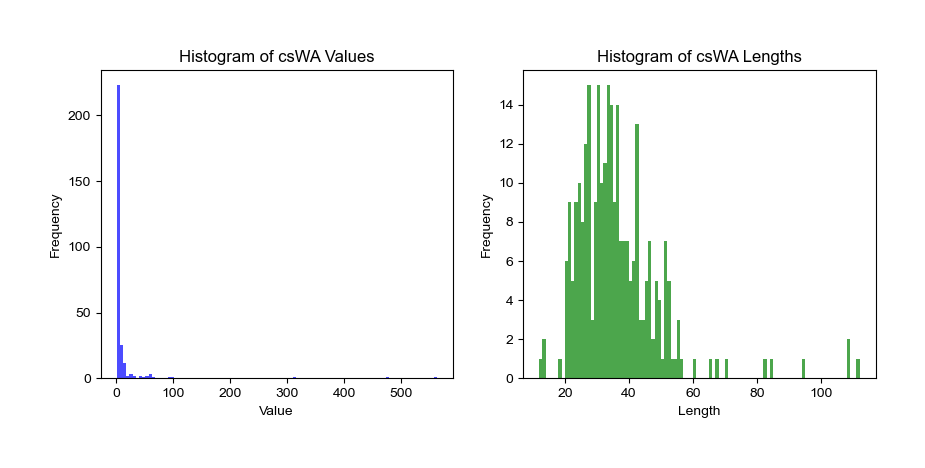

In [32]:
# Plot histogram of csWA Values and lengths 
from matplotlib import pyplot as plt
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(csWA['value'], bins=100, color='blue', alpha=0.7)
ax[0].set_title('Histogram of csWA Values')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Frequency')
ax[1].hist(csWA['length'], bins=100, color='green', alpha=0.7)
ax[1].set_title('Histogram of csWA Lengths')
ax[1].set_xlabel('Length')
ax[1].set_ylabel('Frequency')

In [33]:
"""# Export all sense and antisense regions to fasta files 

sense_csWA_seq_path = os.path.join(csRNAseq_dir, 'csWA_OR_sense_sequences.fasta')
antisense_csWA_seq_path = os.path.join(csRNAseq_dir, 'csWA_OR_antisense_sequences.fasta')

with open(sense_csWA_seq_path, 'w') as sense_fasta: 
    for i, row in csWA[csWA['rel_strand'] == 'sense'].iterrows():
        sense_fasta.write(f">{row['location']}|{row['gene_name']}|{row['strand']}\n")
        sense_fasta.write(f"{row['sequence']}\n")

with open(antisense_csWA_seq_path, 'w') as antisense_fasta: 
    for i, row in csWA[csWA['rel_strand'] == 'antisense'].iterrows():
        antisense_fasta.write(f">{row['location']}|{row['gene_name']}|{row['strand']}\n")
        antisense_fasta.write(f"{row['sequence']}\n")"""

'# Export all sense and antisense regions to fasta files \n\nsense_csWA_seq_path = os.path.join(csRNAseq_dir, \'csWA_OR_sense_sequences.fasta\')\nantisense_csWA_seq_path = os.path.join(csRNAseq_dir, \'csWA_OR_antisense_sequences.fasta\')\n\nwith open(sense_csWA_seq_path, \'w\') as sense_fasta: \n    for i, row in csWA[csWA[\'rel_strand\'] == \'sense\'].iterrows():\n        sense_fasta.write(f">{row[\'location\']}|{row[\'gene_name\']}|{row[\'strand\']}\n")\n        sense_fasta.write(f"{row[\'sequence\']}\n")\n\nwith open(antisense_csWA_seq_path, \'w\') as antisense_fasta: \n    for i, row in csWA[csWA[\'rel_strand\'] == \'antisense\'].iterrows():\n        antisense_fasta.write(f">{row[\'location\']}|{row[\'gene_name\']}|{row[\'strand\']}\n")\n        antisense_fasta.write(f"{row[\'sequence\']}\n")'

In [52]:
# Create another collection with 25bp upstream and downstream of each region 

distance = 50

promoter_regions = [] 

for i, row in csWA.iterrows():
    if row['strand'] == '+':
        start = row['start'] - distance
        end = row['start'] + distance
    else:
        start = row['end'] - distance
        end = row['end'] + distance
    promoter_regions.append({
        'chrom': row['chrom'],
        'start': start,
        'end': end,
        'csRNAscore': row['value'],
        'strand': row['strand'],
        'gene_strand': row['gene_strand'],
        'gene_name': row['gene_name'],
        'location': f"{row['chrom']}:{start}-{end}"
    })

promoter_regions = pd.DataFrame(promoter_regions)
promoter_regions['sequence'] = promoter_regions.apply(
    lambda row: get_sequence(genome_seq, row['chrom'], row['start'], row['end'], row['strand']), axis=1
)
promoter_regions['rel_strand'] = np.where(promoter_regions['strand'] == promoter_regions['gene_strand'], 'sense', 'antisense')

# how many sense and antisense regions are there?
print(f"Number of sense regions: {np.sum(promoter_regions['rel_strand'] == 'sense')}")
print(f"Number of antisense regions: {np.sum(promoter_regions['rel_strand'] == 'antisense')}")

promoter_regions

Number of sense regions: 162
Number of antisense regions: 119


,chrom,start,end,csRNAscore,strand,gene_strand,gene_name,location,sequence,rel_strand
0,Chr4,10527130,10527230,562.590346,+,-,Or5-9E108,Chr4:10527130-10527230,CAAGCGCAGTTCCCTTTTCTACGCTATAGTTCGATAGTTCTCGATG...,antisense
1,Chr10,1963589,1963689,473.125627,+,-,Or5-9E241,Chr10:1963589-1963689,CAGTTTATGTGAGCGCAAGCGCAATAGGCAGTTATACTTGCGCGAT...,antisense
2,Chr12,8761285,8761385,311.071569,+,+,Or5-L22,Chr12:8761285-8761385,TCTCGCGCAGACGCCACGGTGACTACGAGGCTCGCTCTTACGTGAT...,sense
3,Chr4,10603156,10603256,101.522030,+,-,Or5-9E118,Chr4:10603156-10603256,ACGCGCAAGCGCAGTTCCCTTTTCCACTGCCCCAGTAGTTCTTGGC...,antisense
4,Chr7,5138088,5138188,95.484292,-,+,Or5-U64,Chr7:5138088-5138188,CGTTCTACGTACCTTTAACCATCGATATAGTCGGGTCACCCACTTG...,antisense
...,...,...,...,...,...,...,...,...,...,...
276,Chr11,9784252,9784352,1.050000,-,-,Or5-E21,Chr11:9784252-9784352,TCAACGTAATACGTATCTGACTATATTTGCAATTCAATTATCTTCT...,sense
277,Chr11,13626572,13626672,1.040000,-,-,Or5-9E348,Chr11:13626572-13626672,TATTATATATCGCACATAATAGAATGGTAGTCGGTCGTATTTTAAT...,sense
278,Chr11,13613177,13613277,1.040000,-,-,Or5-9E345,Chr11:13613177-13613277,CATTCTCTGATACCAAGGAATAAAGCCGGACGAGATAAAATTTTGA...,sense
279,Chr11,13606725,13606825,1.040000,-,-,Or5-9E353,Chr11:13606725-13606825,TGCTAAAATATTTATTCATTTCTCATGCCGAAGAATGGAACGAGAA...,sense


In [35]:
# Get Or5-L22
promoter_regions[promoter_regions['gene_name'] == 'Or5-L22']

,chrom,start,end,csRNAscore,strand,gene_strand,gene_name,location,sequence,rel_strand
2,Chr12,8761285,8761385,311.071569,+,+,Or5-L22,Chr12:8761285-8761385,TCTCGCGCAGACGCCACGGTGACTACGAGGCTCGCTCTTACGTGAT...,sense
139,Chr12,8761154,8761254,2.480000,-,+,Or5-L22,Chr12:8761154-8761254,AATCGATTGACTAAAGCTATCGGACTTGTTACTTGGGTAACAATGT...,antisense


In [36]:
# Export all sense and antisense regions to fasta files 

sense_promoter_seq_path = os.path.join(csRNAseq_dir, 'csWA_OR_promoter_sense_sequences.fasta')
antisense_promoter_seq_path = os.path.join(csRNAseq_dir, 'csWA_OR_promoter_antisense_sequences.fasta')

with open(sense_promoter_seq_path, 'w') as sense_fasta: 
    for i, row in promoter_regions[promoter_regions['rel_strand'] == 'sense'].iterrows():
        sense_fasta.write(f">{row['location']}|{row['gene_name']}|{row['strand']}\n")
        sense_fasta.write(f"{row['sequence']}\n")

with open(antisense_promoter_seq_path, 'w') as antisense_fasta: 
    for i, row in promoter_regions[promoter_regions['rel_strand'] == 'antisense'].iterrows():
        antisense_fasta.write(f">{row['location']}|{row['gene_name']}|{row['strand']}\n")
        antisense_fasta.write(f"{row['sequence']}\n")

In [37]:
# run MEME on sense sequences

import subprocess

input_path = os.path.join(csRNAseq_dir, 'csWA_OR_promoter_sense_sequences.fasta')
output_dir = os.path.join(csRNAseq_dir, 'csWA_OR_promoter_sense_sequences_meme')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

 # MEME command
meme_command = [
    "meme", input_path, 
    "-oc", output_dir, 
    "-dna", 
    "-nmotifs", "10", # number of motifs # "-maxsize", "1000000", # increases the maximum size MEME will consider 
    "-evt", "0.01", # E-value threshold 
    "-minw", "10", # minimum motif width 
    "-maxw", "20", # maximum motif width
    "-minsites", "10", # minimum number of sites required for a motif 
    "-maxiter", "1000", # maximum number of iterations 
    "-mod", "zoops", # options: zoops (0 or 1), oops (1), anr (any) 
]

print(meme_command) 
subprocess.run(meme_command, check=True)

['meme', '../raw-data/OBir/csRNAseq/csWA_OR_promoter_sense_sequences.fasta', '-oc', '../raw-data/OBir/csRNAseq/csWA_OR_promoter_sense_sequences_meme', '-dna', '-nmotifs', '10', '-evt', '0.01', '-minw', '10', '-maxw', '20', '-minsites', '10', '-maxiter', '1000', '-mod', 'zoops']


The output directory '../raw-data/OBir/csRNAseq/csWA_OR_promoter_sense_sequences_meme' already exists.
Its contents will be overwritten.
BACKGROUND: using background model of order 0
PRIMARY (classic): n 162 p0 162 p1 0 p2 0
SEQUENCE GROUP USAGE-- Starts/EM: p0; Trim: p0; pvalue: p0; nsites: p0,p1,p2
SEEDS: maxwords 16200 highwater mark: seq 162 pos 90
BALANCE: samples 162 chars 16200 nodes 1 chars/node 16200
Initializing the motif probability tables for 2 to 162 sites...
nsites = 162
Done initializing.

seqs=   162, min_w= 100, max_w=  100, total_size=    16200

motif=1
SEED DEPTHS: 10 20 40 80 160 162
SEED WIDTHS: 10 14 19 20
em: w=  20, psites= 162, iter= 130 
motif=2
SEED DEPTHS: 10 20 40 80 160 162
SEED WIDTHS: 10 14 19 20
em: w=  20, psites= 162, iter= 180 
motif=3
SEED DEPTHS: 10 20 40 80 160 162
SEED WIDTHS: 10 14 19 20
em: w=  20, psites= 162, iter= 160 
motif=4
SEED DEPTHS: 10 20 40 80 160 162
SEED WIDTHS: 10 14 19 20
em: w=  20, psites= 162, iter= 230 
motif=5
SEED DEPTHS: 1

CompletedProcess(args=['meme', '../raw-data/OBir/csRNAseq/csWA_OR_promoter_sense_sequences.fasta', '-oc', '../raw-data/OBir/csRNAseq/csWA_OR_promoter_sense_sequences_meme', '-dna', '-nmotifs', '10', '-evt', '0.01', '-minw', '10', '-maxw', '20', '-minsites', '10', '-maxiter', '1000', '-mod', 'zoops'], returncode=0)

In [53]:
import subprocess

input_path = os.path.join(csRNAseq_dir, 'csWA_OR_promoter_antisense_sequences.fasta')
output_dir = os.path.join(csRNAseq_dir, 'csWA_OR_promoter_antisense_sequences_meme')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

 # MEME command
meme_command = [
    "meme", input_path, 
    "-oc", output_dir, 
    "-dna", 
    "-nmotifs", "10", # number of motifs # "-maxsize", "1000000", # increases the maximum size MEME will consider 
    "-evt", "0.01", # E-value threshold 
    "-minw", "10", # minimum motif width 
    "-maxw", "20", # maximum motif width
    "-minsites", "10", # minimum number of sites required for a motif 
    "-maxiter", "1000", # maximum number of iterations 
    "-mod", "zoops", # options: zoops (0 or 1), oops (1), anr (any) 
]

print(meme_command) 
subprocess.run(meme_command, check=True)

['meme', '../raw-data/OBir/csRNAseq/csWA_OR_promoter_antisense_sequences.fasta', '-oc', '../raw-data/OBir/csRNAseq/csWA_OR_promoter_antisense_sequences_meme', '-dna', '-nmotifs', '10', '-evt', '0.01', '-minw', '10', '-maxw', '20', '-minsites', '10', '-maxiter', '1000', '-mod', 'zoops']


The output directory '../raw-data/OBir/csRNAseq/csWA_OR_promoter_antisense_sequences_meme' already exists.
Its contents will be overwritten.
BACKGROUND: using background model of order 0
PRIMARY (classic): n 119 p0 119 p1 0 p2 0
SEQUENCE GROUP USAGE-- Starts/EM: p0; Trim: p0; pvalue: p0; nsites: p0,p1,p2
SEEDS: maxwords 11900 highwater mark: seq 119 pos 90
BALANCE: samples 119 chars 11900 nodes 1 chars/node 11900
Initializing the motif probability tables for 2 to 119 sites...
nsites = 119
Done initializing.

seqs=   119, min_w= 100, max_w=  100, total_size=    11900

motif=1
SEED DEPTHS: 10 20 40 80 119
SEED WIDTHS: 10 14 19 20
em: w=  20, psites= 119, iter=  30 
motif=2
SEED DEPTHS: 10 20 40 80 119
SEED WIDTHS: 10 14 19 20
em: w=  20, psites= 119, iter= 130 
motif=3
SEED DEPTHS: 10 20 40 80 119
SEED WIDTHS: 10 14 19 20
em: w=  20, psites= 119, iter= 120 
motif=4
SEED DEPTHS: 10 20 40 80 119
SEED WIDTHS: 10 14 19 20
em: w=  20, psites= 119, iter= 100 
motif=5
SEED DEPTHS: 10 20 40 80 1

CompletedProcess(args=['meme', '../raw-data/OBir/csRNAseq/csWA_OR_promoter_antisense_sequences.fasta', '-oc', '../raw-data/OBir/csRNAseq/csWA_OR_promoter_antisense_sequences_meme', '-dna', '-nmotifs', '10', '-evt', '0.01', '-minw', '10', '-maxw', '20', '-minsites', '10', '-maxiter', '1000', '-mod', 'zoops'], returncode=0)

In [54]:
def normalize_pspm(pspm):
    """
    Normalize a Position-Specific Probability Matrix (PSPM) so that each column sums to 1.
    If a column sums to 0.9, add 0.1 to the smallest value.
    If a column sums to 1.1, subtract 0.1 from the largest value.
    
    Parameters:
        pspm (numpy.ndarray): A 4 x n matrix representing the PSPM.
    
    Returns:
        numpy.ndarray: The normalized PSPM.
    """
    # Ensure the input is a numpy array
    pspm = np.array(pspm)
    
    # Iterate over each column in the PSPM
    for col_idx in range(pspm.shape[1]):
        column = pspm[:, col_idx]
        col_sum = np.sum(column)
        
        if np.isclose(col_sum, 0.9, atol=1e-3):  # Check if column sum is close to 0.9
            min_idx = np.argmin(column)  # Index of the smallest value in the column
            pspm[min_idx, col_idx] += 0.1  # Add 0.1 to the smallest value
            
        elif np.isclose(col_sum, 1.1, atol=1e-3):  # Check if column sum is close to 1.1
            max_idx = np.argmax(column)  # Index of the largest value in the column
            pspm[max_idx, col_idx] -= 0.1  # Subtract 0.1 from the largest value
            
        # If column sums to neither 0.9 nor 1.1, leave it unchanged
    
    return pspm

In [55]:
def parse_meme_output(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    
    # Define regex patterns to extract relevant information
    motif_pattern = re.compile(r"MOTIF\s+(\S+)\s+MEME-\d+\s+width\s=\s+(\d+)\s+sites\s=\s+(\d+)\s+llr\s=\s+(\d+)\s+E-value\s=\s+([\d\.\-e]+)")
    
    # Regex patterns to extract the lines corresponding to each base (A, C, G, T)
    line_A_pattern = re.compile(r"Simplified\s+A\s+([:a-zA-Z0-9]+)")
    line_C_pattern = re.compile(r"pos.-specific\s+C\s+([:a-zA-Z0-9]+)")
    line_G_pattern = re.compile(r"probability\s+G\s+([:a-zA-Z0-9]+)")
    line_T_pattern = re.compile(r"matrix\s+T\s+([:a-zA-Z0-9]+)")

    # Regex pattern to extract numbers from each line
    number_pattern = re.compile(r"(\d+)")

    # Find all motifs that match the motif pattern
    motifs = motif_pattern.findall(content)
    
    # Create a DataFrame to store results
    motif_data = pd.DataFrame(motifs, columns=['Motif', 'Width', 'Sites', 'LLR', 'E-value'])
    
    # Convert numeric columns to appropriate types
    motif_data['Width'] = pd.to_numeric(motif_data['Width'])
    motif_data['Sites'] = pd.to_numeric(motif_data['Sites'])
    motif_data['LLR'] = pd.to_numeric(motif_data['LLR'])
    motif_data['E-value'] = pd.to_numeric(motif_data['E-value'])

    # Initialize a list to store the extracted PSPMs
    pspsm_data = []

    # Function to transform a string representation to a list of floats based on the rules
    def transform_pspm_line(line):
        transformed = []
        for char in line:
            if char == ':':
                transformed.append(0.0)
            elif char == 'a':
                transformed.append(1.0)
            elif char.isdigit():
                transformed.append(int(char) / 10.0)  # Convert number to a decimal
        return transformed

    # Extract PSPMs for each motif
    motif_blocks = re.split(r'MOTIF\s+\S+\s+MEME-\d+', content)[1:]  # Split content by motif occurrences
    for block in motif_blocks:
        # Extract each row corresponding to A, C, G, and T
        row_A = line_A_pattern.search(block)
        row_C = line_C_pattern.search(block)
        row_G = line_G_pattern.search(block)
        row_T = line_T_pattern.search(block)
        
        if row_A and row_C and row_G and row_T:
            # Transform each line using the custom rules
            A_values = transform_pspm_line(row_A.group(1))
            C_values = transform_pspm_line(row_C.group(1))
            G_values = transform_pspm_line(row_G.group(1))
            T_values = transform_pspm_line(row_T.group(1))

            # Combine into a matrix
            pspsm_data.append(np.array([A_values, C_values, G_values, T_values]))
        else:
            print("Error extracting PSPM data.")
            pspsm_data.append(None)  # In case extraction fails for some motif

    motif_data['PSPM_ACGT'] = pspsm_data # pspsm_data #normalize_pspm(pspsm_data)

    return motif_data

In [56]:
all_motifs = pd.DataFrame(columns=['Motif', 'Width', 'Sites', 'LLR', 'E-value', 'PSPM_ACGT'])
output_path = os.path.join(csRNAseq_dir, 'csWA_OR_promoter_antisense_sequences_meme', 'meme.txt')
motif_data = parse_meme_output(output_path)    
motif_data

,Motif,Width,Sites,LLR,E-value,PSPM_ACGT
0,RCGCAAGCGCARTTSVYWTT,20,65,1169,3.400000e-298,"[[0.3, 0.0, 0.0, 0.0, 1.0, 0.9, 0.0, 0.0, 0.0,..."
1,CAGTCBAKTBYGYGCADTCG,20,63,918,9.200000e-192,"[[0.0, 1.0, 0.0, 0.0, 0.2, 0.0, 0.7, 0.0, 0.0,..."
2,GTWCRCATSTDYSTTAAAMR,20,46,623,1.500000e-99,"[[0.1, 0.0, 0.5, 0.0, 0.7, 0.0, 0.8, 0.0, 0.0,..."
3,RMKCWDTASKTCTTSGCGTT,20,26,434,9.700000e-71,"[[0.5, 0.3, 0.0, 0.0, 0.6, 0.3, 0.0, 1.0, 0.0,..."
4,ATACSSTTSKACKC,14,14,172,1.900000e-05,"[[1.0, 0.1, 1.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0,..."


In [57]:
# normalize PSPM 
motif_data['PSPM_ACGT'] = motif_data['PSPM_ACGT'].apply(normalize_pspm)

In [58]:
motif_data['PSPM_ACGT'].iloc[0].sum(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [59]:
motif_data

,Motif,Width,Sites,LLR,E-value,PSPM_ACGT
0,RCGCAAGCGCARTTSVYWTT,20,65,1169,3.400000e-298,"[[0.3, 0.0, 0.0, 0.0, 1.0, 0.8, 0.0, 0.0, 0.0,..."
1,CAGTCBAKTBYGYGCADTCG,20,63,918,9.200000e-192,"[[0.0, 1.0, 0.0, 0.0, 0.2, 0.1, 0.7, 0.0, 0.0,..."
2,GTWCRCATSTDYSTTAAAMR,20,46,623,1.500000e-99,"[[0.1, 0.0, 0.5, 0.0, 0.7, 0.0, 0.8, 0.0, 0.0,..."
3,RMKCWDTASKTCTTSGCGTT,20,26,434,9.700000e-71,"[[0.5, 0.3, 0.0, 0.0, 0.6, 0.3, 0.1, 1.0, 0.0,..."
4,ATACSSTTSKACKC,14,14,172,1.900000e-05,"[[1.0, 0.1, 1.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0,..."


In [60]:
# Drop all rows except the first 
#motif_data = motif_data.iloc[[0]].reset_index(drop=True)

## Write meme file for FIMO

In [61]:
# Define the output directory and file path
output_dir = os.path.join(csRNAseq_dir, 'csWA_OR_promoter_antisense_sequences_meme')
output_file = os.path.join(output_dir, 'motifs.meme')

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Open the output file for writing in MEME format
with open(output_file, 'w') as f:
    # Write the header for the MEME file
    f.write("MEME version 5.0\n\n")
    f.write("ALPHABET= ACGT\n\n")
    f.write("strands: + -\n\n")
    f.write("Background letter frequencies (uniform):\n")
    f.write("A 0.25 C 0.25 G 0.25 T 0.25\n\n")
    
    # Iterate through the motif data and write each motif
    for i, row in motif_data.iterrows():
        # Write the MOTIF header
        f.write(f"MOTIF {row['Motif']}\n")
        f.write(f"letter-probability matrix: alength=4 w={row["Width"]} nsites={row['Sites']} E={row['E-value']}\n")
        
        # Write the PSPM matrix
        np.savetxt(f, row['PSPM_ACGT'].T, fmt="%.1f", delimiter="\t")
        f.write("\n")

Export region upstream of all ORs to a fasta file

In [62]:
# Get sequences for each OR region of interest
OR_rois['seq'] = OR_rois.apply(lambda row: get_sequence(genome_seq, row['chrom'], row['start'], row['end'], row['strand']), axis=1)

# Verify length of sequences 
or_lengths = OR_rois['seq'].apply(len)
print(f"Minimum OR sequence length: {or_lengths.min()}")
print(f"Maximum OR sequence length: {or_lengths.max()}")

# Export to Fasta file 
or_fasta_path = os.path.join(csRNAseq_dir, 'ORs_1000bp_upstream_CDS.fasta')
with open(or_fasta_path, 'w') as or_fasta:
    for i, row in OR_rois.iterrows():
        or_fasta.write(f">{row['gene_name']}|{row['chrom']}:{row['start']}-{row['end']}|{row['strand']}\n")
        or_fasta.write(f"{row['seq']}\n")

Minimum OR sequence length: 1000
Maximum OR sequence length: 1000


### FIMO
FIMO scans a set of sequences for individual matches to each of the motifs you provide

In [63]:
output_dir_path = os.path.join(csRNAseq_dir, 'csWA_OR_promoter_antisense_sequences_fimo')
sequence_path = os.path.join(csRNAseq_dir, 'ORs_1000bp_upstream_CDS.fasta')
motif_path = os.path.join(csRNAseq_dir, 'csWA_OR_promoter_antisense_sequences_meme', 'motifs.meme')

# Ensure the output directory exists
os.makedirs(output_dir_path, exist_ok=True)

# Run the FIMO command
fimo_command = [
    "fimo",
    "--oc", output_dir_path,
    "--thresh", "0.0001", # Set the threshold for motif matches
    motif_path,
    sequence_path
]

print(fimo_command)
subprocess.run(fimo_command, check=True)

['fimo', '--oc', '../raw-data/OBir/csRNAseq/csWA_OR_promoter_antisense_sequences_fimo', '--thresh', '0.0001', '../raw-data/OBir/csRNAseq/csWA_OR_promoter_antisense_sequences_meme/motifs.meme', '../raw-data/OBir/csRNAseq/ORs_1000bp_upstream_CDS.fasta']


Using motif +RCGCAAGCGCARTTSVYWTT of width 20.
Using motif -RCGCAAGCGCARTTSVYWTT of width 20.
Finding best site passing the output threshold in each of the 498 sequences.
Found a best site in 250 sequences.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.0003
#   Estimated pi_0=1
Using motif +CAGTCBAKTBYGYGCADTCG of width 20.
Using motif -CAGTCBAKTBYGYGCADTCG of width 20.
Finding best site passing the output threshold in each of the 498 sequences.
Found a best site in 215 sequences.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00061
#   Estimated pi_0=1
Using motif +GTWCRCATSTDYSTTAAAMR of width 20.
Using motif -GTWCRCATSTDYSTTAAAMR of width 20.
Finding best site passing the output threshold in each of the 498 sequences.
Found a best site in 222 sequences.
Computing q-values.


CompletedProcess(args=['fimo', '--oc', '../raw-data/OBir/csRNAseq/csWA_OR_promoter_antisense_sequences_fimo', '--thresh', '0.0001', '../raw-data/OBir/csRNAseq/csWA_OR_promoter_antisense_sequences_meme/motifs.meme', '../raw-data/OBir/csRNAseq/ORs_1000bp_upstream_CDS.fasta'], returncode=0)

## Read in FIMO TSV

In [67]:
fimo_results_path = os.path.join(output_dir_path, 'fimo.tsv')
fimo_results = pd.read_csv(fimo_results_path, sep='\t')
# Drop rows with nan sequence_name 
fimo_results = fimo_results.dropna(subset=['sequence_name']).reset_index(drop=True)
# Get gene_name 
fimo_results['sequence_name'] = fimo_results['sequence_name'].astype(str)  # Ensure sequence_name is string type
fimo_results['gene_name'] = fimo_results['sequence_name'].apply(lambda x: x.split('|')[0])
# Print strand results 
print(f"Number of motifs on + strand: {fimo_results[fimo_results['strand'] == '+'].shape[0]}")
print(f"Number of motifs on - strand: {fimo_results[fimo_results['strand'] == '-'].shape[0]}")

# Print number of hits with FDR q-value < 0.05 
fimo_results['q-value'] = fimo_results['q-value'].astype(float)  # Ensure q-value is float type
print(f"Number of motifs with FDR q-value < 0.05: {fimo_results[fimo_results['q-value'] < 0.05].shape[0]} out of {fimo_results.shape[0]} total motifs.")

# Print number of hits with q-value < 0.1 and strand is - 
print(f"Number of motifs with q-value < 0.1 and strand is -: {fimo_results[(fimo_results['q-value'] < 0.1) & (fimo_results['strand'] == '-')].shape[0]} out of {fimo_results.shape[0]} total motifs.")

# Print number of unique gene_name with q-value < 0.1 and strand is -
print(f"Number of unique gene_name with q-value < 0.1 and strand is -: {fimo_results[(fimo_results['q-value'] < 0.1) & (fimo_results['strand'] == '-')]['gene_name'].nunique()} out of {fimo_results['gene_name'].nunique()} total unique gene_name.")

# Print number of unique 9E genes with a hit with q-value < 0.1 and strand is -
fimo_results['nine_exon'] = fimo_results['gene_name'].apply(lambda x: '9E' in x)
print(f"Number of unique 9E genes with a hit with q-value < 0.1 and strand is -: {fimo_results[(fimo_results['q-value'] < 0.1) & (fimo_results['strand'] == '-') & (fimo_results['nine_exon'])]['gene_name'].nunique()} out of {fimo_results[(fimo_results['q-value'] < 0.1) & (fimo_results['strand'] == '-')]['gene_name'].nunique()}.")

fimo_results

Number of motifs on + strand: 242
Number of motifs on - strand: 776
Number of motifs with FDR q-value < 0.05: 508 out of 1018 total motifs.
Number of motifs with q-value < 0.1 and strand is -: 532 out of 1018 total motifs.
Number of unique gene_name with q-value < 0.1 and strand is -: 224 out of 393 total unique gene_name.
Number of unique 9E genes with a hit with q-value < 0.1 and strand is -: 209 out of 224.


,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,gene_name,nine_exon
0,RCGCAAGCGCARTTSVYWTT,NaN,Or5-9E56|Chr2,16707481.0,16707500.0,-,31.32930,8.250000e-13,8.190000e-08,GCGCAAGCGCAATTGACTTT,Or5-9E56,True
1,RCGCAAGCGCARTTSVYWTT,NaN,Or5-9E57|Chr2,16713011.0,16713030.0,-,31.32930,8.250000e-13,8.190000e-08,GCGCAAGCGCAATTGACTTT,Or5-9E57,True
2,RCGCAAGCGCARTTSVYWTT,NaN,Or5-9E58|Chr2,16720178.0,16720197.0,-,31.32930,8.250000e-13,8.190000e-08,GCGCAAGCGCAATTGACTTT,Or5-9E58,True
3,RCGCAAGCGCARTTSVYWTT,NaN,Or5-9E59|Chr2,16725445.0,16725464.0,-,31.32930,8.250000e-13,8.190000e-08,GCGCAAGCGCAATTGACTTT,Or5-9E59,True
4,RCGCAAGCGCARTTSVYWTT,NaN,Or5-9E20|Chr2,2463443.0,2463462.0,-,31.03660,3.190000e-12,8.190000e-08,GCGCAAGCGCAATTGATTTT,Or5-9E20,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1013,ATACSSTTSKACKC,NaN,Or5-V4|Chr3,14760355.0,14760368.0,-,7.43000,9.940000e-05,1.000000e+00,ACACCCTTGTGCAC,Or5-V4,False
1014,RCGCAAGCGCARTTSVYWTT,NaN,Or5-9E281|Chr10,12837625.0,12837644.0,-,-8.32927,9.960000e-05,3.450000e-01,TCCCAAGCGTAAGTGAAATT,Or5-9E281,True
1015,RCGCAAGCGCARTTSVYWTT,NaN,Or5-9E283|Chr10,12846824.0,12846843.0,-,-8.32927,9.960000e-05,3.450000e-01,TCCCAAGCGTAAGTGAAATT,Or5-9E283,True
1016,GTWCRCATSTDYSTTAAAMR,NaN,Or5-U67|Chr8,1272067.0,1272086.0,-,3.44444,1.000000e-04,3.070000e-01,ATTCGCTACTTTATTGAAGG,Or5-U67,False


## SEA
Simple Enrichment Analysis

In [50]:
output_dir_path = os.path.join(csRNAseq_dir, 'csWA_OR_promoter_antisense_sequences_meme', 'sea')
sequence_path = os.path.join(csRNAseq_dir, 'ORs_500bp_upstream_CDS.fasta')
motif_path = os.path.join(csRNAseq_dir, 'csWA_OR_promoter_antisense_sequences_meme', 'motifs.meme')

# Ensure the output directory exists
os.makedirs(output_dir_path, exist_ok=True)

# Run the SEA command
sea_command = [
    "sea",
    "--oc", output_dir_path,
    "--m", motif_path,
    "--p", sequence_path
]

print(sea_command)
subprocess.run(sea_command, check=True)

['sea', '--oc', '../raw-data/OBir/csRNAseq/csWA_OR_promoter_antisense_sequences_meme/sea', '--m', '../raw-data/OBir/csRNAseq/csWA_OR_promoter_antisense_sequences_meme/motifs.meme', '--p', '../raw-data/OBir/csRNAseq/ORs_500bp_upstream_CDS.fasta']


# Checking alphabets in 1 motif files.
# Loading motifs from file '../raw-data/OBir/csRNAseq/csWA_OR_promoter_antisense_sequences_meme/motifs.meme'
# Alphabet: DNA
# Positive sequences "../raw-data/OBir/csRNAseq/ORs_500bp_upstream_CDS.fasta" - training: 449 hold-out: 49
# Negative sequences are shuffled primary sequences (2-order) - training: 449 hold-out: 49
# Estimating background model from control sequences.
# Background: A 0.341 C 0.159 G 0.159 T 0.341
# Background order: 2 Background size: 84
# Using Fisher Exact test for p-values.
# Computing q-values.
#   Cannot estimate pi_0 accurately from fewer than 100 p-values.
#   Total p-values = 5. Using pi_zero = 1.0.
# Positive sequences "../raw-data/OBir/csRNAseq/ORs_500bp_upstream_CDS.fasta" - training: 449 hold-out: 49
# Negative sequences are shuffled primary sequences (2-order) - training: 449 hold-out: 49
# Estimating background model from control sequences.
# Background: A 0.341 C 0.159 G 0.159 T 0.341
# Background order: 2 Bac

CompletedProcess(args=['sea', '--oc', '../raw-data/OBir/csRNAseq/csWA_OR_promoter_antisense_sequences_meme/sea', '--m', '../raw-data/OBir/csRNAseq/csWA_OR_promoter_antisense_sequences_meme/motifs.meme', '--p', '../raw-data/OBir/csRNAseq/ORs_500bp_upstream_CDS.fasta'], returncode=0)